In [1]:
#Importing important packages
import iris
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import datetime
import numpy as np
import iris.coords as icoords
import iris.coord_categorisation
import iris.quickplot as qplt 

In [2]:
# defining a funtion to take area average
def area_average(cube):
    
    if cube.coord('latitude').bounds is None:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
    
    grid_areas = iris.analysis.cartography.area_weights(cube)
    average = cube.collapsed(['latitude','longitude'],iris.analysis.MEAN, weights=grid_areas)
    
    return average

In [3]:
#defining function to merge cube list into single large cube
def merge_cubes(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    time_coord = cubes[0].coord('time')
    n=1
    for cube in cubes:
        ensemble_coord = icoords.AuxCoord(n, standard_name='realization')
        new_cube = cube.copy()
        new_cube.add_aux_coord(ensemble_coord)
        new_cube.remove_coord('time')
        new_cube.add_dim_coord(time_coord,0)
        new_cube.remove_coord('forecast_reference_time')
        big_cube.append(new_cube)
        n+=1
    
    return big_cube.merge_cube()

In [4]:
#importing long control cube - to calculate 5-month rolling mean prior to Jan eruption
long_control_cube = iris.load('/shared/netscratch/lrm49/Laura/ENSO_anom_picontrol.nc')

In [5]:
#setting file path and importing short control ensembles - to calculate 5-month rolling mean prior to July eruption
dir_in = '/shared/netscratch/lrm49/Laura/Control/'
coupled_cntl = ['u-bu651','u-bv666','u-bv668','u-bv669','u-bv670','u-bv674','u-bv676','u-bv677','u-bv678']

In [6]:
#merging cube list to one cube
long_control_cube = merge_cubes(long_control_cube)

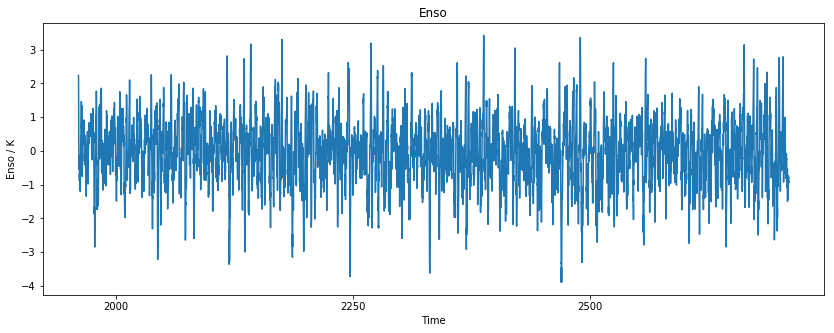

In [7]:
plt.figure(figsize = (14,5))
qplt.plot(long_control_cube)

In [8]:
#extracting surface temperature cubes for short controls
sat_cubes = iris.cube.CubeList()

for job_id in coupled_cntl:
    
    dynamic_cube = iris.load(dir_in+job_id+'_dynamics_vars.nc')
    cube_1 = dynamic_cube.extract('surface_temperature')[0]

    sat_cubes.append(cube_1)

In [9]:
##El Nino 3.4 Index Lat/Long constraints
nino_constraint = iris.Constraint(longitude=lambda v: -170+360 <= v <= -120+360,latitude=lambda v: -5 <= v <= 5)

nino_cubes = iris.cube.CubeList()

for cube in sat_cubes:
    nino = cube.extract(nino_constraint)
    
    nino_cubes.append(nino)

In [10]:
#Taking average SST over constrained area
nino_charc = iris.cube.CubeList()

for cube in nino_cubes:
    lat_long = area_average(cube)
    
    nino_charc.append(lat_long)

In [11]:
#merging into single cube
nino_charc_merge = merge_cubes(nino_charc)

In [12]:
#calculating mean of short controls
mean_control = nino_charc_merge.collapsed('realization',iris.analysis.MEAN)

/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'realization'.
  warnings.warn(msg.format(self.name()))


In [14]:
#creating climatology from short control mean
iris.coord_categorisation.add_month(mean_control,'time',name='month')
climatology_all_controls = mean_control.aggregated_by('month',iris.analysis.MEAN) #aggregating by month
print(climatology_all_controls.data)

[298.77935171 299.05285469 299.30246088 299.75888163 299.81961326
 299.60436849 299.22345536 298.67320224 298.42663551 298.59387295
 298.78985302 298.82168538]


In [15]:
#creating 10-year climatology
climatology_long = np.tile(climatology_all_controls.data, 10)

In [16]:
#calculating anomaly for each short ensemble
anomally = nino_charc_merge - climatology_long
#first 12 months
anomally = anomally[:,0:12]

In [17]:
#finding starting timec(Jan) for each short control so that it can be matched to same time in long control (see above)
for i in range(0,9):
        
    print(sat_cubes[i].coord('time')[0])

DimCoord([2191-01-16 00:00:00], bounds=[[2191-01-01 00:00:00, 2191-02-01 00:00:00]], standard_name=u'time', calendar=u'360_day', var_name='time')
DimCoord([2209-01-16 00:00:00], bounds=[[2209-01-01 00:00:00, 2209-02-01 00:00:00]], standard_name=u'time', calendar=u'360_day', var_name='time')
DimCoord([2466-01-16 00:00:00], bounds=[[2466-01-01 00:00:00, 2466-02-01 00:00:00]], standard_name=u'time', calendar=u'360_day', var_name='time')
DimCoord([2072-01-16 00:00:00], bounds=[[2072-01-01 00:00:00, 2072-02-01 00:00:00]], standard_name=u'time', calendar=u'360_day', var_name='time')
DimCoord([2285-01-16 00:00:00], bounds=[[2285-01-01 00:00:00, 2285-02-01 00:00:00]], standard_name=u'time', calendar=u'360_day', var_name='time')
DimCoord([2703-01-16 00:00:00], bounds=[[2703-01-01 00:00:00, 2703-02-01 00:00:00]], standard_name=u'time', calendar=u'360_day', var_name='time')
DimCoord([2635-01-16 00:00:00], bounds=[[2635-01-01 00:00:00, 2635-02-01 00:00:00]], standard_name=u'time', calendar=u'360_d

In [18]:
# extracting 6 months prior and post Jan eruption from long control
long_control_list = iris.cube.CubeList()

long_control_0 = long_control_cube[2766:2778]
long_control_1 = long_control_cube[2982:2994]
long_control_2 = long_control_cube[6066:6078]
long_control_3 = long_control_cube[1338:1350]
long_control_4 = long_control_cube[3894:3906]
long_control_5 = long_control_cube[8910:8922]
long_control_6 = long_control_cube[8094:8106]
long_control_7 = long_control_cube[7290:7302]
long_control_8 = long_control_cube[1578:1590]

long_control_list.append(long_control_0)
long_control_list.append(long_control_1)
long_control_list.append(long_control_2)
long_control_list.append(long_control_3)
long_control_list.append(long_control_4)
long_control_list.append(long_control_5)
long_control_list.append(long_control_6)
long_control_list.append(long_control_7)
long_control_list.append(long_control_8)

In [19]:
#defining positive, negative, and zero lines for plot below
positive = []
for n in range(0,12):
    n = 0.4
    positive.append(n)
    
negative = []
for n in range(0,12):
    n = -0.4
    negative.append(n)
    
zero = []
for n in range(0,12):
    n = 0
    zero.append(n)

In [20]:
#defining new timescale
time = range(-6,6)


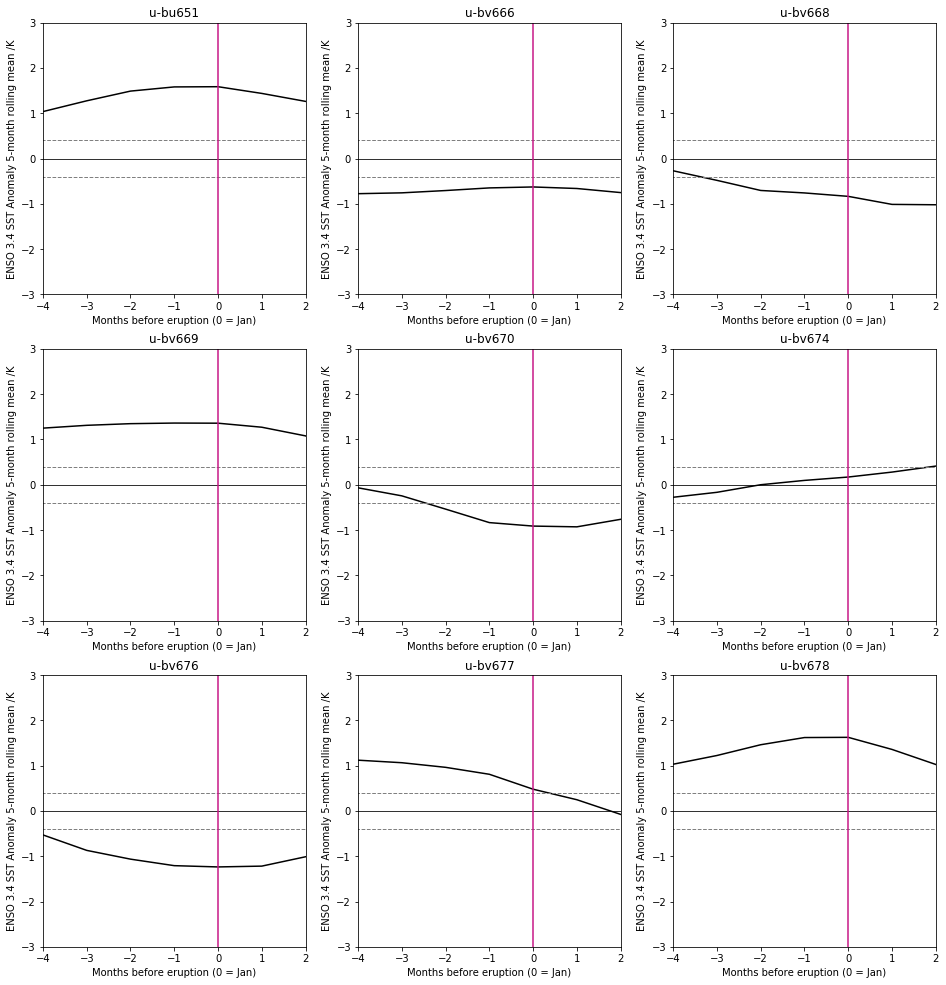

In [21]:
### JANUARY ###

## Rolling 5-month mean for 4 months prior and 2 months post eruption

plt.figure(figsize = (16,17))
labels = ['u-bu651','u-bv666','u-bv668','u-bv669','u-bv670','u-bv674','u-bv676','u-bv677','u-bv678']

for n in range(0,9):
    df = pd.Series(long_control_list[n].data)
    rolling_mean = df.rolling(5,center=True).mean() # 5-month rolling mean
    plt.subplot(3,3,n+1)
    plt.plot(time, rolling_mean, color = 'black')
    plt.plot(time, positive, linestyle = '--', color = 'grey', linewidth=1)
    plt.plot(time, negative, linestyle = '--', color = 'grey', linewidth=1)
    plt.plot(time, zero, linestyle = '-', alpha = 0.8, color = 'black', linewidth=1)
    plt.plot([time[6], time[6]],[-4,4], color = 'mediumvioletred')
    plt.ylim(-3,3)
    plt.xlim(-4,2)
    plt.ylabel('ENSO 3.4 SST Anomaly 5-month rolling mean /K')
    plt.xlabel('Months before eruption (0 = Jan)')
    plt.title(str(labels[n]))
    
plt.savefig('ENSO_Recharacterised_Jan_Rolling_Mean.pdf')

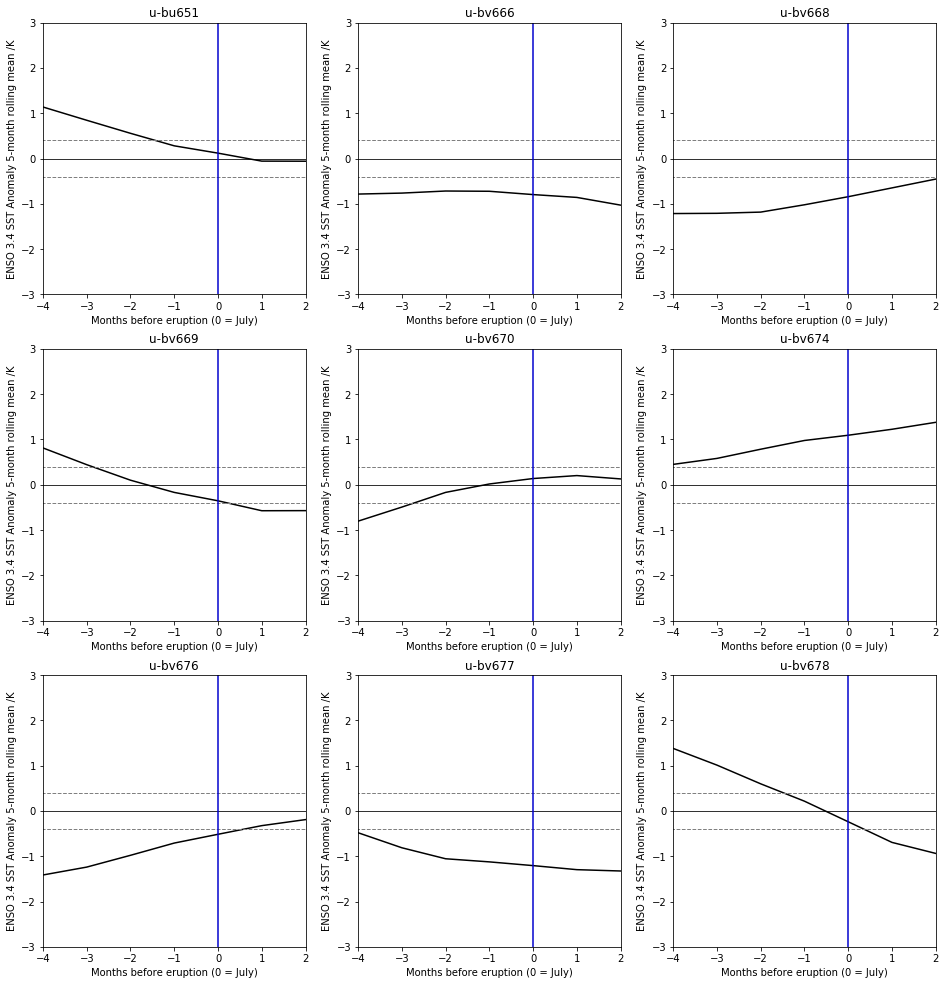

In [22]:
### JULY ###

## Rolling 5-month mean for 4 months prior and 2 months post eruption

plt.figure(figsize = (16,17))

for n in range(0,9):
    plt.subplot(3,3,n+1)
    df = pd.Series(anomally[n].data)
    rolling_mean = df.rolling(5,center=True).mean() # 5-month rolling mean
    plt.plot(time,rolling_mean, label = coupled_cntl[n], c='black' )
    plt.plot(time, positive, linestyle = '--', color = 'grey', linewidth=1)
    plt.plot(time, negative, linestyle = '--', color = 'grey', linewidth=1)
    plt.plot(time, zero, linestyle = '-', alpha = 0.8, color = 'black', linewidth=1)
    plt.plot([time[6], time[6]],[-4,4], color = 'mediumblue')
    plt.ylim(-3,3)
    plt.xlim(-4,2)
    plt.ylabel('ENSO 3.4 SST Anomaly 5-month rolling mean /K')
    plt.xlabel('Months before eruption (0 = July)')
    plt.title(str(labels[n]))
    
plt.savefig('ENSO_Recharacterised_July_Rolling_Mean.pdf')